In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Carregar o conjunto de dados
df = pd.read_csv("../data/commerce_dataset_clean.csv", sep=";")

In [3]:
# Converter a coluna 'dtme' para datetime e definir como índice do DataFrame
df["dtme"] = pd.to_datetime(df["dtme"])
df.set_index("dtme", inplace=True)

In [4]:
# Agregar os totais de vendas por dia
sales_daily = df.groupby("dtme")["total"].sum()

# Visualizar as primeiras entradas da série agregada
sales_daily.head()

dtme
2019-01-01    4745.1810
2019-01-02    1945.5030
2019-01-03    2078.1285
2019-01-04    1623.6885
2019-01-05    3536.6835
Name: total, dtype: float64

In [5]:
# Definir e ajustar o modelo ARIMA
ARIMA_model = pm.auto_arima(
    sales_daily,
    start_p=1,
    start_q=1,
    test="adf",  # use adftest para encontrar o 'd' ótimo
    max_p=3,
    max_q=3,  # máximo p e q
    m=1,  # frequência da série (se m==1, seasonal é definido como FALSE automaticamente)
    d=None,  # deixar o modelo determinar 'd'
    seasonal=False,  # Sem sazonalidade para ARIMA padrão
    trace=False,  # logs
    error_action="warn",  # mostra erros ('ignore' silencia esses)
    suppress_warnings=True,
    stepwise=True,
)

# Mostrar o resumo do modelo
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   89
Model:                        SARIMAX   Log Likelihood                -778.284
Date:                Mon, 26 Feb 2024   AIC                           1560.569
Time:                        20:58:25   BIC                           1565.546
Sample:                    01-01-2019   HQIC                          1562.575
                         - 03-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3628.8399    181.728     19.969      0.000    3272.660    3985.020
sigma2      2.307e+06   4.37e+05      5.284      0.000    1.45e+06    3.16e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 5.69
Prob(Q):                              0.63   Prob(JB):                         0.06
Heteroskedasticity (H):               1.69   Skew:                             0.59
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

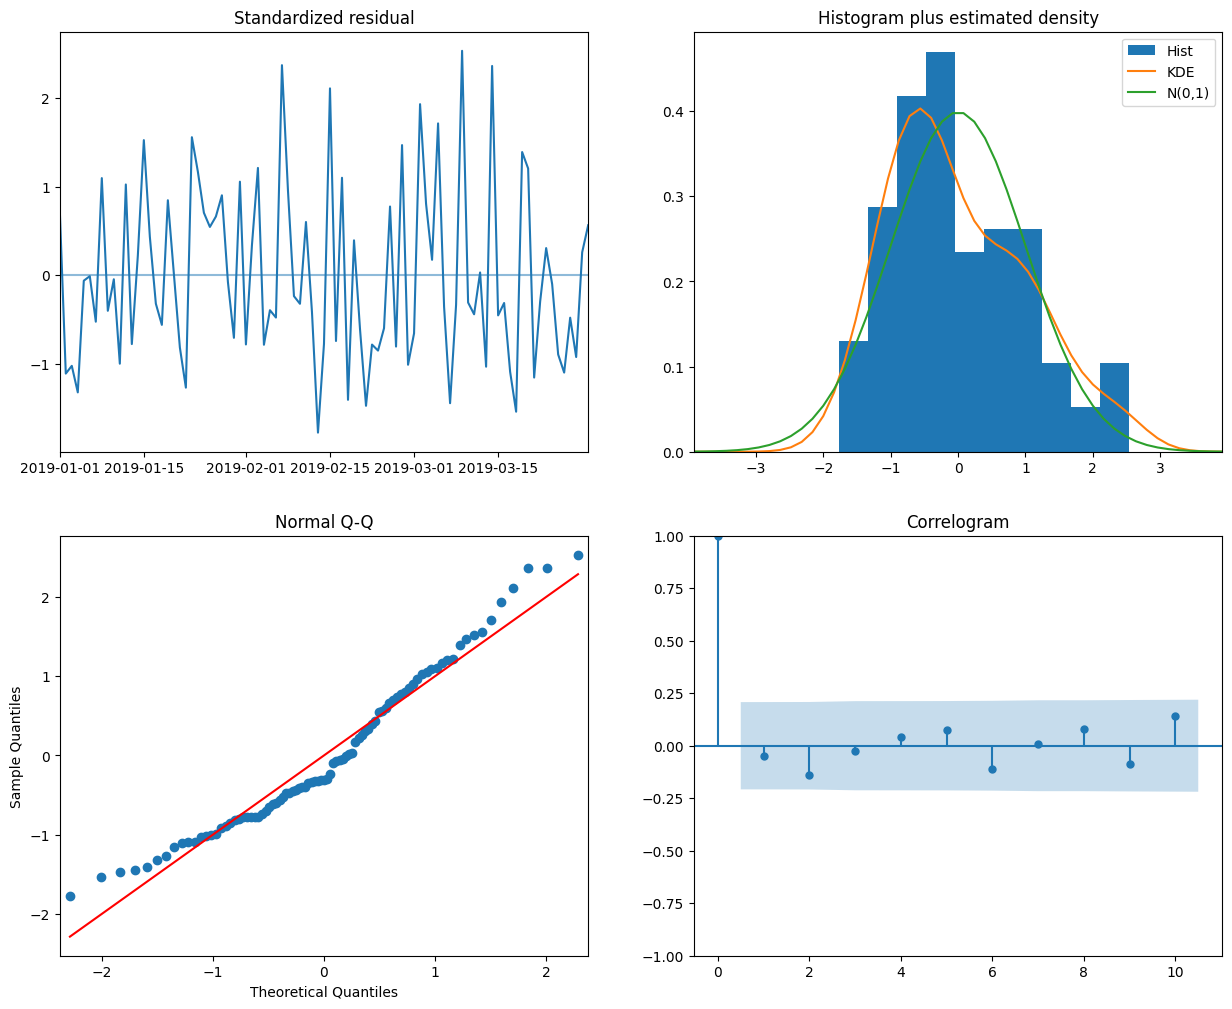

In [6]:
ARIMA_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [7]:
# Função para plotar o gráfico de previsão
def forecast(ARIMA_model, periods=24):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(
        sales_daily.index[-1] + pd.DateOffset(days=1), periods=n_periods, freq="D"
    )

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15, 7))
    plt.plot(sales_daily, color="#1f76b4")
    plt.plot(fitted_series, color="darkgreen")
    plt.fill_between(
        lower_series.index, lower_series, upper_series, color="k", alpha=0.15
    )

    plt.title("ARIMA/SARIMA - Forecast of Daily Sales")
    plt.show()

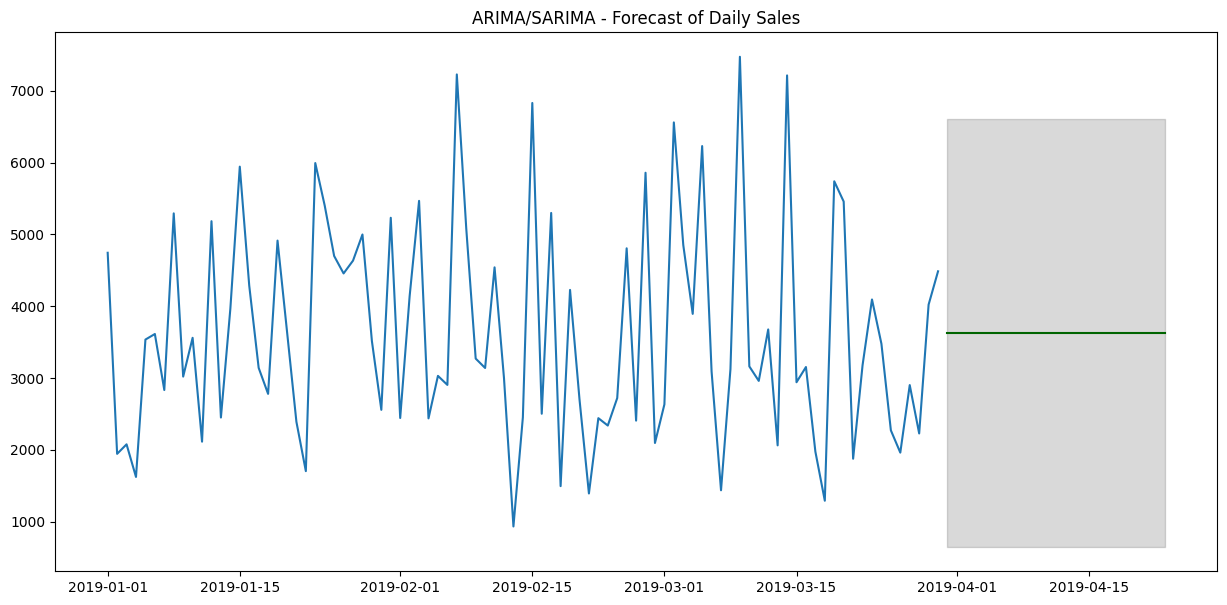

In [8]:
# Print forecast
forecast(ARIMA_model)